# Evaluation of the Best-Performing Fold of the Best Hyperparameters

## Setup:

## Connect to Remote Compute Environment

First ensure we are connected to the correct VSCode Remote Kernel.

In [1]:
!uname -nv && ls /

nazvioo10z #138~18.04.1-Ubuntu SMP Fri Jun 24 14:14:03 UTC 2022
bin	  dev	lib    libx32  notebooks  root	srv	 tmp
boot	  etc	lib32  media   opt	  run	storage  usr
datasets  home	lib64  mnt     proc	  sbin	sys	 var


## Upgrade Python Modules

Install the latest version of Tensorflow, and install Tensorflow

In [2]:
!pip3 install --quiet --upgrade tensorflow==2.11.0
!pip3 install --quiet tensorflow_addons

## Python Environment Checks

Instantiate Python Kernel and load Python modules.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

try:
    tf.config.experimental.set_memory_growth(
        tf.config.list_physical_devices('GPU')[0],
        enable=True
    )
except IndexError as e:
    display("No GPU Found")
    
import tensorflow_addons as tfa
import numpy as np
import keras
from typing import Literal, Union, TypeVar
import pickle

# Custom utilities function
from models import TransferLearningModel
from utilities import *

2023-05-01 20:33:20.574188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 20:33:21.278284: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-01 20:33:21.278374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-05-01 20:33:21.278382: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Double-check GPU is available.

In [4]:
display(tf.__version__)
display(tf.config.list_physical_devices('GPU'))
display(tf.test.gpu_device_name())

'2.11.0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

'/device:GPU:0'

# Model Preparation

Begin preparing the model's execution environment. First, we start by defining some constants:

In [5]:
IMG_SIZE  : tuple[int, int] = (299, 299)
AUTOTUNE  : Literal = tf.data.AUTOTUNE
RNG_SEED  : int = 1337

dataset_directory: str = "./"

## Prepare Datasets

For the evaluation, we only have to load our hold-out test set.


In [6]:
# InceptionV3 requires image tensors with a shape of (299, 299, 3) 
# ds_train: tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_train_299")
# ds_valid: tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_valid_299")
ds_test : tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_test")

# For K-Fold Cross Validation
# ds_train_and_valid: tf.data.Dataset = ds_train.concatenate(ds_test)

# Batching, caching, and performance optimisations are *not* performed at this stage
# Since we are doing K-Fold validation

# configure_for_performance(ds_train)
# configure_for_performance(ds_valid)
ds_test = configure_for_performance(ds_test)

In [7]:
tf.data.experimental.cardinality(ds_test)

<tf.Tensor: shape=(), dtype=int64, numpy=4>

(128, 299, 299, 3)
Batched
(128, 299, 299, 3)
Batched
(128, 299, 299, 3)
Batched
(57, 299, 299, 3)
Batched


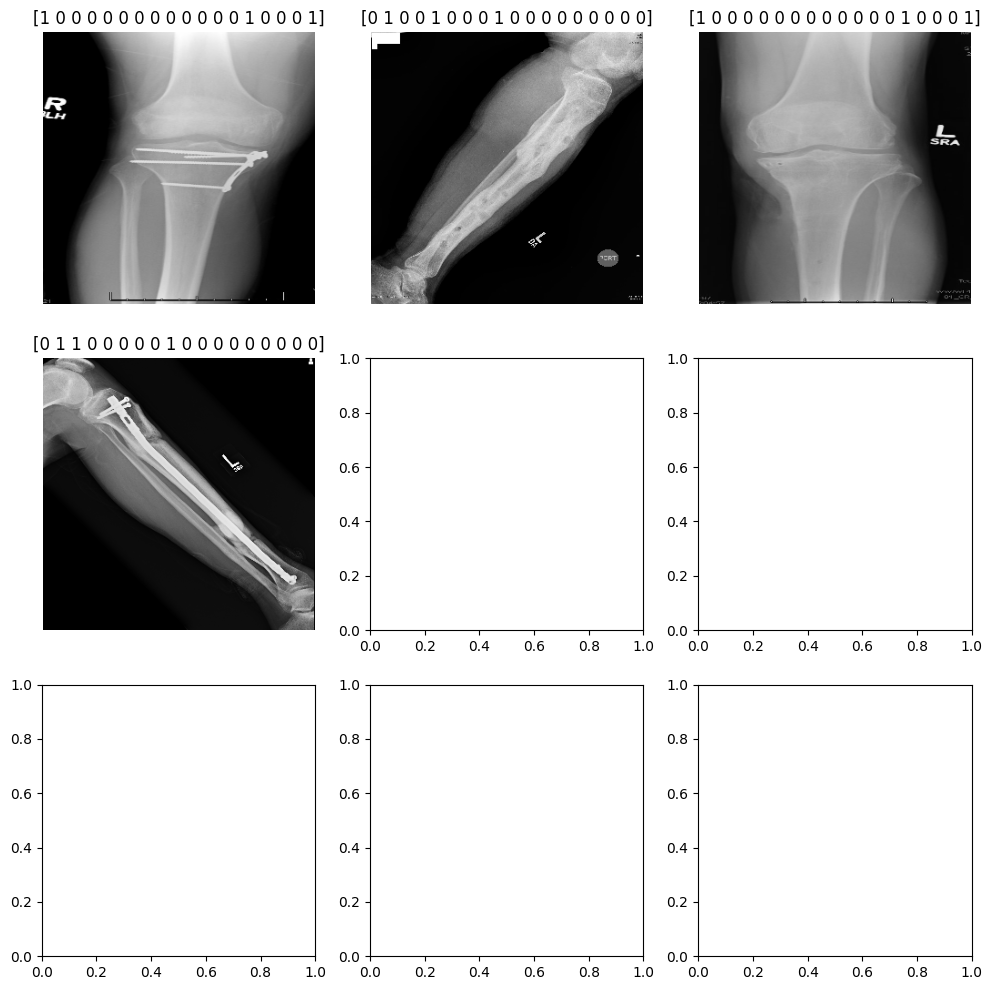

In [8]:
preview_dataset(ds_test)

# Final Model Evaluation

## Hyperparameters:

Regime I:
* batch_size: 1600
* dropout_rate: 0.2

Regime II:
* learning_rate: 0.001
* epsilon_rate: 1e-5

## Load Model Checkpoint

In [9]:
final_model = tf.keras.models.load_model('final-model-checkpoint')

# Check its architecture
final_model.summary()


Model: "transfer_learning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 299, 299, 3)]     0         
                                                                 
 Data_Augmentation_Pipeline   (None, 299, 299, 3)      0         
 (Sequential)                                                    
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 RUST_Score_Classifier (Sequ  (None, 18)               2758930   
 ential)                                                         
                                                                 
 InceptionV3_TransferLearnin  (None, 18)               24561714  
 g (Sequential)                                                  
                                           

## Evaluate Model on Unseen Holdout Test Set

In [10]:
final_model.evaluate(ds_test)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
4/4 [==============================] - 6s 359ms/step - loss: 0.2450 - auc: 0.8904 - precision: 0.8803 - recall: 0.4092 - f1_score: 0.2460


[0.24502234160900116,
 0.8903758525848389,
 0.8802816867828369,
 0.40916529297828674,
 0.2460245043039322]